## Sentiment Analysis

#### Importing required libraries

In [4]:
import pandas as pd   # pandas for data manipulation
import pyodbc   # pyodbc for SQL Server connection
import nltk   # nltk for natural language processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer   # SentimentIntensityAnalyzer from VADER for sentiment analysis

#### Download the VADER lexicon for sentiment analysis

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### Connect to SQL database and retrieve customer review data

In [6]:
def fetch_data_from_sql():
    conn_str = (
        "Driver={SQL Server};"
        "Server=DESKTOP-27MEC5L\SQLEXPRESS;"
        "Database=PortfolioProject_MarketingAnalytics;"
        "Trusted_Connection=yes;"
    )
    conn = pyodbc.connect(conn_str)
    query = "SELECT ReviewID, CustomerID, ProductID, ReviewDate, Rating, ReviewText FROM fact_customer_reviews"
    df = pd.read_sql(query, conn)
    conn.close()
    return df

#### Fetch the customer reviews data from the SQL database

In [7]:
customer_reviews_df = fetch_data_from_sql()

#### Initialize the VADER sentiment analyzer

In [8]:
sia = SentimentIntensityAnalyzer()

#### Calculate sentiment scores using VADER

In [9]:
def calculate_sentiment(review):
    sentiment = sia.polarity_scores(review)   # Calculate sentiment scores for the review text using VADER
    return sentiment['compound']   # Returns the compound score (-1 to 1, where -1 is very negative, 0 is neutral, 1 is very positive)

#### Create more nuanced sentiment categories by combining the sentiment score and the review rating.
###### This helps identify cases where the rating and text sentiment don't align.

In [10]:
def categorize_sentiment(score, rating):
    if score > 0.05:   # Positive sentiment score
        if rating >= 4:
            return 'Positive'   # High rating and positive sentiment
        elif rating == 3:
            return 'Mixed Positive'   # Neutral rating but positive sentiment
        else:
            return 'Mixed Negative'   # Low rating but positive sentiment
    elif score < -0.05:   # Negative sentiment score
        if rating <= 2:
            return 'Negative'   # Low rating and negative sentiment
        elif rating == 3:
            return 'Mixed Negative'   # Neutral rating but negative sentiment
        else:
            return 'Mixed Positive'   # High rating but negative sentiment
    else:   # Neutral sentiment score
        if rating >= 4:
            return 'Positive'   # High rating with neutral sentiment
        elif rating <= 2:
            return 'Negative'   # Low rating with neutral sentiment
        else:
            return 'Neutral'   # Neutral rating and neutral sentiment

#### Create buckets for sentiment scores

In [11]:
def sentiment_bucket(score):
    if score >= 0.5:
        return '0.5 to 1.0'   # Strongly positive sentiment
    elif 0.0 <= score < 0.5:
        return '0.0 to 0.49'   # Mildly positive sentiment
    elif -0.5 <= score < 0.0:
        return '-0.49 to 0.0'   # Mildly negative sentiment
    else:
        return '-1.0 to -0.5'   # Strongly negative sentiment

#### Apply sentiment analysis to calculate sentiment scores for each review and stores the results in a new column

In [12]:
customer_reviews_df['SentimentScore'] = customer_reviews_df['ReviewText'].apply(calculate_sentiment)

#### Apply sentiment categorization to each row, using both the sentiment score and rating

In [13]:
customer_reviews_df['SentimentCategory'] = customer_reviews_df.apply(
    lambda row: categorize_sentiment(row['SentimentScore'], row['Rating']), axis=1)

#### Apply the bucketing function to categorize sentiment scores into ranges

In [14]:
customer_reviews_df['SentimentBucket'] = customer_reviews_df['SentimentScore'].apply(sentiment_bucket)

#### Display the first few rows of the processed DataFrame to verify the results

In [15]:
print(customer_reviews_df.head())

   ReviewID  CustomerID  ProductID  ReviewDate  Rating  \
0         1          77         18  23.12.2023       3   
1         2          80         19  25.12.2024       5   
2         3          50         13  26.01.2025       4   
3         4          78         15  21.04.2025       3   
4         5          64          2  16.07.2023       3   

                             ReviewText  SentimentScore SentimentCategory  \
0  Average experience, nothing special.         -0.3089    Mixed Negative   
1            The quality is  top-notch.          0.0000          Positive   
2    Five stars for the quick delivery.          0.0000          Positive   
3   Good quality, but could be cheaper.          0.2382    Mixed Positive   
4  Average experience, nothing special.         -0.3089    Mixed Negative   

  SentimentBucket  
0    -0.49 to 0.0  
1     0.0 to 0.49  
2     0.0 to 0.49  
3     0.0 to 0.49  
4    -0.49 to 0.0  


#### Save the enriched data to a CSV file for further analysis or visualization.

In [62]:
customer_reviews_df.to_csv('fact_customer_reviews_with_sentiment.csv', index=False)

## Data Visualization

In [19]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


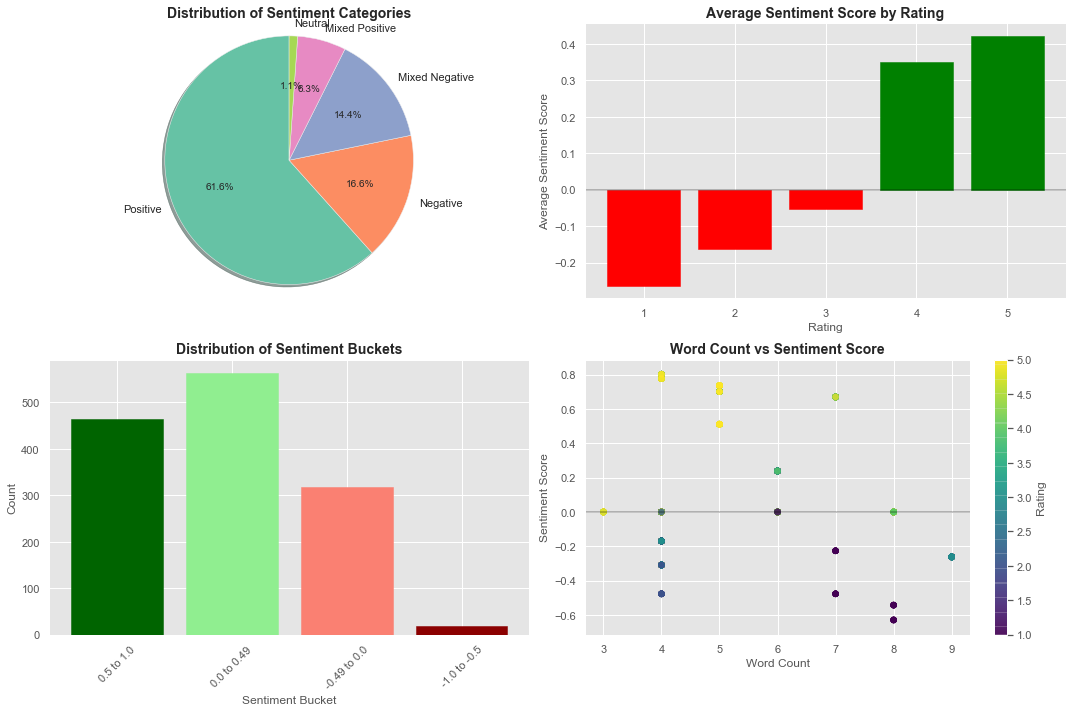

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# If reading from CSV:
# customer_reviews_df = pd.read_csv('fact_customer_reviews_with_sentiment.csv')

# Set the style
plt.style.use('ggplot')
sns.set_palette("Set2")

# Create a figure with multiple plots
fig = plt.figure(figsize=(15, 10))

# Plot 1: Sentiment Category Distribution (Pie Chart)
plt.subplot(2, 2, 1)
sentiment_counts = customer_reviews_df['SentimentCategory'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        startangle=90, shadow=True)
plt.title('Distribution of Sentiment Categories', fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plot 2: Average Sentiment Score by Rating (Bar Chart)
plt.subplot(2, 2, 2)
avg_sentiment = customer_reviews_df.groupby('Rating')['SentimentScore'].mean().reset_index()
bars = plt.bar(avg_sentiment['Rating'], avg_sentiment['SentimentScore'])

# Color bars based on sentiment value
for i, bar in enumerate(bars):
    if avg_sentiment['SentimentScore'].iloc[i] > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')
        
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Add a line at y=0
plt.title('Average Sentiment Score by Rating', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks(avg_sentiment['Rating'])

# Plot 3: Sentiment Bucket Distribution (Bar Chart)
plt.subplot(2, 2, 3)
bucket_order = ['0.5 to 1.0', '0.0 to 0.49', '-0.49 to 0.0', '-1.0 to -0.5']
bucket_counts = customer_reviews_df['SentimentBucket'].value_counts().reindex(bucket_order)
bars = plt.bar(bucket_counts.index, bucket_counts.values)

# Color bars based on sentiment bucket
colors = ['darkgreen', 'lightgreen', 'salmon', 'darkred']
for i, bar in enumerate(bars):
    bar.set_color(colors[i])
    
plt.title('Distribution of Sentiment Buckets', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Bucket')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Word Count vs Sentiment Score (Scatter Plot)
plt.subplot(2, 2, 4)
customer_reviews_df['WordCount'] = customer_reviews_df['ReviewText'].apply(lambda x: len(x.split()))
plt.scatter(customer_reviews_df['WordCount'], customer_reviews_df['SentimentScore'], 
            alpha=0.7, c=customer_reviews_df['Rating'], cmap='viridis')
plt.colorbar(label='Rating')
plt.title('Word Count vs Sentiment Score', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Score')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Add a line at y=0

plt.tight_layout()
plt.savefig('sentiment_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()